# Bearing Anomaly Detection using Machine Learning

## 1. Introduction

Condition monitoring of an equipment is one of the crucial aspect one must conduct while operating a plant. The program can help identify the health state of the equipment so the plant operator can make necessary action to mitigate the equipment failure.

The most common way to perform condition monitoring is to look at each sensor measurement from the machine and to set a minimum and maximum value limit on the measurement. If the measurement value is within the bounds, then the equpment is healthy. If the measurement value is outside the bouds, then the equipment is unhealthy and a warning is sent.

Due to signals are measured from many sensors, the system is prone to either sending a large number of false alarms, i.e. sending unnecessary alarms or missing alarms, i.e. not sending required alarms. In order to mitigate this situation, it is necessary to have a reliable computational method which can analyze and give correct judgement from the combined data collected from various measurements of the available sensors.

In recent years many novel methods have been introduced to help plant operator correctly analyze the combined signals, thanks to the rapid machine learning and deep learning application to the industry. 

I recently came across a great [article](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7) written by Vegard Flovik where he highlighted two different approaches of unsupervised machine learning methods to detect anomaly of a working machine to help operator monitor its condition. In the article, he introduced two different types of unsupervised learning methods to solve the anomaly detection problem and provided practical code example;
* Principal Component Analysis (PCA) combined with Mahalanobis distance
* Autoencoder

For the sake of understanding the introduced concept in the article, I have followed his code and tried to reproduce the results.


## 2. Data

The bearing dataset was provided  provided by the Center for Intelligent Maintenance Systems (IMS), University of Cincinnati and is available at [Kaggle](https://www.kaggle.com/vinayak123tyagi/bearing-dataset). There exists 3 datasets in total and each dataset consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Following the article, the second dataset was selected to perform this study.

For the second dataset, there exists 984 data files with a measurement interval of 10 minutes between each two adjacent data file, and each data file has 20,480 measurements. This means a measurement exercise of the equipment was conducted every 10 minutes and in each exercise 20,480 measurements were taken.

For each measurement, there are 4 different parameters recorded, representing 4 different types of bearings of the equipment. This project is essentially studying the interactions between the 4 bearings. For each data file, Vegard Flovik took an average of all 20,480 measurements and the final dataset has 984 rows and 4 columns. I believe the purpose of taking the average is for simplicity and the reduction of noise among individual measurements. However, one can actually train a more sophisticated model by using the large number of individual measurements without taking the average.


In [5]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    # each file consists of 20480 rows of data with the sampling rate set at 20 kHz
    # data in each two adjacent files are measured 10 minutes away from each other
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    
    # for the purpose of the anomaly detection study, we only keep the mean of the 20480 data points in each file
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.index = pd.to_datetime(
    merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()

print('data shape:', merged_data.shape)

merged_data.head()

data shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


Plotting the raw data with respect to its index (time of observation) we get the following plot

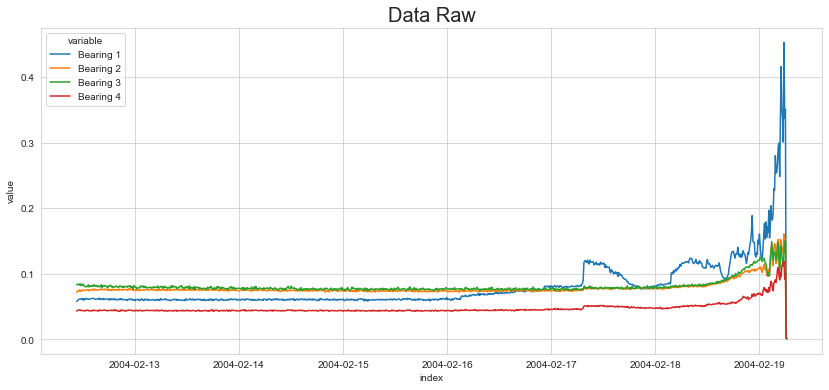

In [7]:
dataset_melt_merged_data = pd.melt(merged_data.reset_index(), id_vars='index')

plt.figure(figsize=(14, 6))
sns_plot = sns.lineplot(x='index', y='value', hue='variable',
                        data=dataset_melt_merged_data).set_title('Data Raw', fontsize=20)

plt.show()

From the plot above we notice that Bearing 1 started to deviate from original trend after 2004-02-16 while others still performed quite normal until after 2004-02-18. In traditional Statistical Process Control (SPC), if we are unlucky, we may not have selected Bearing 1 to be monitored and may not have detected any issue before 2004-02-19, when a breakdown event occurred.

## 3. Define train/test data

Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions), and test on the remaining parts of the dataset leading up to the bearing failure.

<AxesSubplot:>

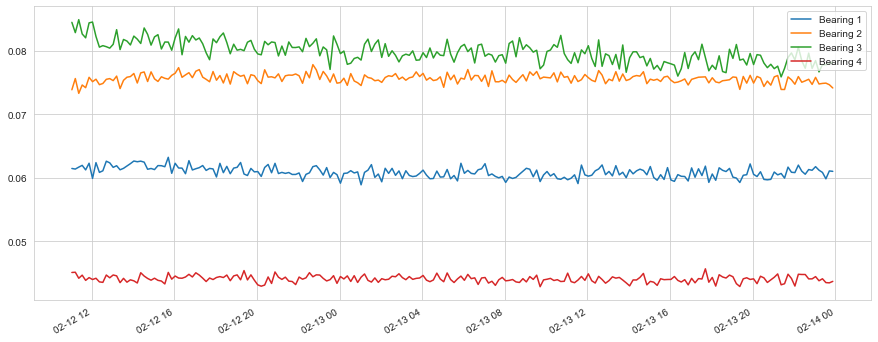

In [8]:
train_data = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test_data = merged_data['2004-02-13 23:52:39':]
train_data.plot(figsize = (15,6))

Next, preprocessing tools of Scikit-learn will be used to scale the imput variables of the model. Here, the MinMaxScaler wil rescale the data to be in the range of [0,1]

In [9]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train_data), 
                              columns = train_data.columns, 
                              index = train_data.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test_data), 
                             columns = test_data.columns, 
                             index = test_data.index)

In [10]:
X_test.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-13 23:52:39,0.489779,0.187746,0.255713,0.298511
2004-02-14 00:02:39,0.354621,0.227843,0.244457,0.425398
2004-02-14 00:12:39,0.249681,0.309895,0.231099,0.254432
2004-02-14 00:22:39,0.303792,0.376130,0.195196,0.608553
2004-02-14 00:32:39,0.610786,0.502812,0.162301,0.380454


## 4. Approach-1: Multivariate Statistical Analysis (MSA)

The first approach we are going to show is to apply Principal Component Analysis (PCA) in combination with the Mahalanobis distance. Before jumping into the analysis, let's define required functions as per below.

In [11]:
# covariance matrix calculation

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

# Mahalanobis distance calculation


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# outlier detection


def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# threshold value calculation for classifying datapoint as anomaly


def MD_threshold(dist, std_dev=4, verbose=False):
    threshold = np.mean(dist) + np.std(dist) * std_dev
    return threshold

# Check if matrix is positive definite


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

Having split the dataset into train and test data, we will now build a model that can detect anomaly from the bearing datasets. This section will be split into two subsection; first is building the model using PCA, second is anomaly detection using Mahalanobis distance.

### 4.1 Principal Component Analysis (PCA) application to the MSA

Dealing with high dimensional data is often computationally challenging. Luckily there are several techniques to reduce the number of variables. One of the main techniques we are going to use here is the Principal Component Analysis (PCA). 

Here, PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. In practice, the covariance matrix of the data is constructed and the eigenvectors of this matrix are computed. The eigenvectors that correspond to the largest eigenvalues (the principal components) can now be used to reconstruct a large fraction of the variance of the original data. The original feature space has now been reduced to the space spanned by a few eigenvectors.

In [12]:
from sklearn.decomposition import PCA

# only keep the first 2 principal components
pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
print(pca.explained_variance_)


[0.06830952 0.02739669]


In [13]:
# X_train_PCA shape: (num_training_examples x num_principal_components)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
# X_test_PCA shape: (num_test_examples x num_principal_components)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

# principal_components_train shape: (num_training_examples x num_principal_components)
principal_components_train = np.array(X_train_PCA.values)
# principal_components_test shape: (num_test_examples x num_principal_components)
principal_components_test = np.array(X_test_PCA.values)

In [14]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.51012041 0.20459247]


From the above output, one can observe that the principal component 1 holds 51.0% of the information while the principal component 2 holds only 20.4% of the information. Also, the other point to note is that while projecting four-dimensional data to a two-dimensional data, 28.6% information was lost.

### 4.2 Anomaly detection using Mahalanobis distance

How to check that an observed point is anomaly? 
Let's consider the problem of estimating that a data point belong to a set of points. The first step would be to find the centroid or center of the set as representative of the set. Intuitively, the closer the sample point to the center of mass, the more likely it belongs to the set. 

However, we also need to know if the set is spread out over a large range or a small range, so that we can decide whether a given distance from the center is noteworthy or not. The simplistic approach is to estimate the standard deviation of the distances of the sample points from the center of mass. By plugging this into the normal distribution we derive the probability of the data point belonging to the same distribution.

The drawback of the above approach was that we assumed the sample points are distributed around the centroid in a spherical manner. When we face a non-spherical distribution, e.g. an ellipsoidal, we would expect the probability of the test point belonging to the set to depend not only on the distance from the centroid, but also on the direction. In those directions where the ellipsoid has a short axis the test point must be closer, while in those where the axis is long the test point can be further away from the center. 

Putting this on a mathematical basis, the ellipsoid that best represents the set’s probability distribution can be estimated by calculating the covariance matrix of the samples. The Mahalanobis distance (MD) is the distance of the test point from the centroid divided by the width of the ellipsoid in the direction of the test point.

In [15]:
# Calculate the covariance matrix and its inverse, based principal components of training data
# cov_matrix/inv_cov_matrix shape: (num_principal_components x num_principal_components)
cov_matrix, inv_cov_matrix = cov_matrix(principal_components_train)

# calculate the mean value for the principal components of training set, as this is used later
# to calculate the Mahalanobis distance to datapoints in the test set
# mean_distr shape: (num_principal_components, )
mean_distr = principal_components_train.mean(axis=0)

# calculate the Mahalanobis distance for training set
# dist_train length: num_training_examples
dist_train = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_train, verbose=False)

# find the threshold value to flag datapoints as an anomaly based on training set
# threshold: a number, type numpy.float64
threshold = MD_threshold(dist_train, std_dev=4)

# calculate the Mahalanobis distance for test set, to be compared with the anomaly threshold
# dist_test length: num_test_examples
dist_test = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_test, verbose=False)

The square of the Mahalanobis distance to the centroid of the distribution should follow chi-square (χ2) distribution if the assumption of normal distributed input variables is fulfilled. This is also the assumption behind the above calculation of the “threshold value” for flagging an anomaly. As this assumption is not necessarily fulfilled in our case, it is beneficial to visualize the distribution of the Mahalanobis distance to set a good threshold value for flagging anomalies.

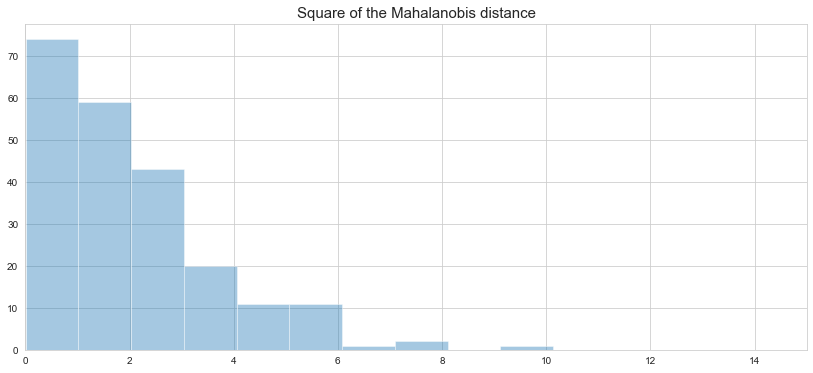

In [16]:
plt.figure(figsize=(14, 6))
sns.distplot(np.square(dist_train),
             bins=10,
             kde=False).set_title('Square of the Mahalanobis distance', fontsize=15)
plt.xlim([0.0, 15])
plt.show()

Visualizing the Mahalanobis distance we get the following plot

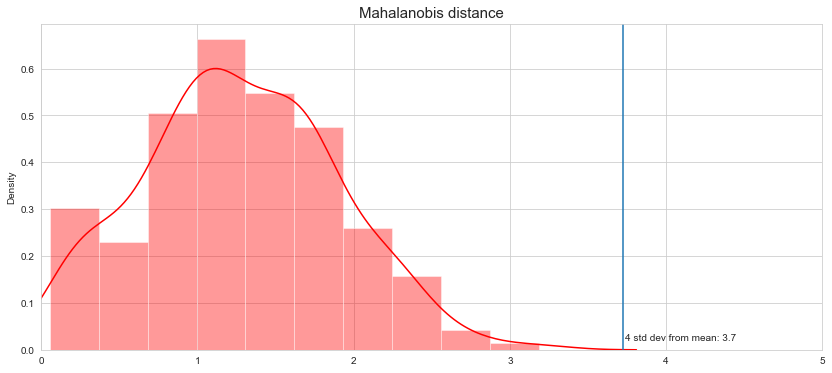

In [17]:
plt.figure(figsize=(14, 6))
sns.distplot(dist_train,
             bins=10,
             kde=True,
             color='red').set_title('Mahalanobis distance', fontsize=15)

plt.axvline(threshold)
plt.text(threshold + 0.01, 0.02, '4 std dev from mean: ' +
         str(round(threshold, 1)))

plt.xlim([0.0, 5])
plt.show()

From the distribution above we can set the anomaly threshold equals to 4 standard deviations from mean of training data's Mahalanobis distances.

Mahalanobis distance of the training data, threshold value and anomaly flag variable for both train and test data can be saved into a dataframe.

In [18]:
# save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe

anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.724605,False
2004-02-14 00:02:39,1.148163,3.724605,False
2004-02-14 00:12:39,1.509998,3.724605,False
2004-02-14 00:22:39,1.849725,3.724605,False
2004-02-14 00:32:39,0.701075,3.724605,False


In [19]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

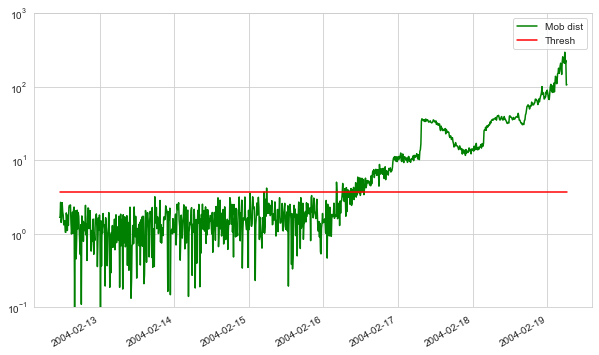

In [20]:
anomaly_alldata.plot(logy=True, figsize=(10, 6), ylim=[
                     1e-1, 1e3], color=['green', 'red'])
plt.show()

The chart above shows that anomaly can be detected between 2004-02-16 to 2004-02-17 without the risk of missing Bearing 1. That's 2 days before when the breakdown actually occurred, on 2004-02-19.

## 5. Approach 2: Autoencoder model for anomaly detection

An autoencoder is a type of artificial neural network used to learn efficient data encodings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input.

In this case study, the distribution of the reconstruction loss of the autoencoder for training data is plotted to identify where normally reconstruction loss lies and come up with a threshold as the upper control limit. One can also compute the 3 standard deviations from the mean of reconstruction loss to determine an appropriate upper control limit, similar to what have been done in the first modeling approach above.

Before building the model, let's import necessary libraries for the analysis.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
import copy
from numpy.random import seed

seed(10)
torch.manual_seed(10)

### 5.1 Define model and train model

Now let's define an autoencoder and train the model accordingly.

In [42]:
class autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ELU(),
            nn.Linear(10, 2),
            nn.ELU())
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ELU(),
            nn.Linear(10, input_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

The ELU (Exponential Linear Unit) activation function is used, which returns x if x > 0 and exp((x)-1) if x < 0). Such choice allows faster convergence of model weigths compared to RELU because of non-null output for x < 0. No difference was observed based on variation of the initialization of weights. This may mean that model training is complete after 100 iterations, and thus results are stable.

In [43]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 10
SHOW_PROGRESS = 5
device = torch.device("cpu")

ae_model = autoencoder(X_train.shape[1]).to(device)
optimiser = optim.Adam(ae_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# train validation split
input_train, input_val, _, _ = train_test_split(
    X_train, X_train, test_size=0.2, random_state=10)

input_train = torch.from_numpy(input_train.values).float().to(device)
input_val = torch.from_numpy(input_val.values).float().to(device)

# create torch dataset
dataset_train = torch.utils.data.TensorDataset(input_train)
dataset_val = torch.utils.data.TensorDataset(input_val)
data_generator_train = torch.utils.data.DataLoader(
    dataset_train, BATCH_SIZE, shuffle=True, drop_last=True)
data_generator_val = torch.utils.data.DataLoader(
    dataset_val, BATCH_SIZE, shuffle=True, drop_last=True)

# training...

epochs = []
losses_train = []
losses_val = []
lowest_loss = 10000

checkpoint = time.time()
for epoch in range(NUM_EPOCHS):
    epochs.append(epoch+1)
    epoch_losses_train = []

    for data_train in data_generator_train:

        ae_model.train()
        optimiser.zero_grad()

        prediction = ae_model(data_train[0])
        loss = criterion(prediction, data_train[0])
        loss.backward()
        optimiser.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_train = np.average(np.array(epoch_losses_train))
    losses_train.append(epoch_losses_train)

    epoch_losses_val = []

    for data_val in data_generator_val:

        ae_model.eval()
        with torch.no_grad():
            prediction = ae_model(data_val[0])
            loss = criterion(prediction, data_val[0])
            epoch_losses_val.append(loss.item())

    epoch_losses_val = np.average(np.array(epoch_losses_val))
    losses_val.append(epoch_losses_val)

    # show training progress at pre-defined interval
    if epoch % SHOW_PROGRESS == SHOW_PROGRESS-1:
        print('Epoch: {} | Train Loss: {:.4} | Val Loss: {:.4}'.format(
            epoch+1, epoch_losses_train, epoch_losses_val))

    # save best model
    if epoch_losses_val < lowest_loss:
        lowest_loss = epoch_losses_val
        best_epoch = epoch + 1
        best_model_wts = copy.deepcopy(ae_model.state_dict())

time_elapsed = time.time() - checkpoint
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('Lowest validation loss: {:.4} at epoch {}'.format(
    lowest_loss, best_epoch))
ae_model.load_state_dict(best_model_wts)

Epoch: 5 | Train Loss: 0.03071 | Val Loss: 0.03282
Epoch: 10 | Train Loss: 0.0265 | Val Loss: 0.0278
Epoch: 15 | Train Loss: 0.02258 | Val Loss: 0.0251
Epoch: 20 | Train Loss: 0.01794 | Val Loss: 0.02038
Epoch: 25 | Train Loss: 0.01574 | Val Loss: 0.01683
Epoch: 30 | Train Loss: 0.01381 | Val Loss: 0.01587
Epoch: 35 | Train Loss: 0.01174 | Val Loss: 0.01448
Epoch: 40 | Train Loss: 0.01057 | Val Loss: 0.01358
Epoch: 45 | Train Loss: 0.01025 | Val Loss: 0.01238
Epoch: 50 | Train Loss: 0.009848 | Val Loss: 0.01314
Epoch: 55 | Train Loss: 0.0101 | Val Loss: 0.01228
Epoch: 60 | Train Loss: 0.009985 | Val Loss: 0.01284
Epoch: 65 | Train Loss: 0.009837 | Val Loss: 0.01217
Epoch: 70 | Train Loss: 0.00961 | Val Loss: 0.0126
Epoch: 75 | Train Loss: 0.009716 | Val Loss: 0.01218
Epoch: 80 | Train Loss: 0.00953 | Val Loss: 0.01196
Epoch: 85 | Train Loss: 0.009706 | Val Loss: 0.01138
Epoch: 90 | Train Loss: 0.009746 | Val Loss: 0.01064
Epoch: 95 | Train Loss: 0.009624 | Val Loss: 0.01146
Epoch: 100 

<All keys matched successfully>

The training results are gathered in a dataframe and plotted against the epochs.

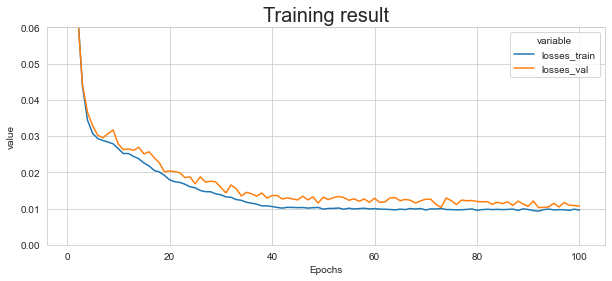

In [44]:
train_result_df = pd.DataFrame(list(zip(epochs, losses_train, losses_val)), columns=['Epochs', 'losses_train', 'losses_val'])

train_result_melt_df = pd.melt(train_result_df, id_vars=['Epochs'], value_vars=['losses_train', 'losses_val'])

# lineplot
plt.figure(figsize=(10, 4))
sns.lineplot(x='Epochs',
             y='value',
             hue='variable',
             data=train_result_melt_df
             ).set_title('Training result', fontsize=20)
plt.ylim(0, 0.06)

plt.show()

### 5.2 Distribution of loss function in the training set

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

From our result, we can use a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

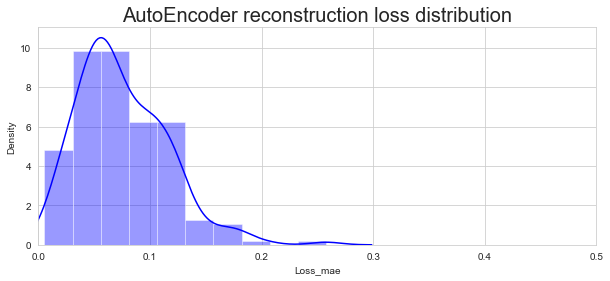

In [37]:
ae_model.eval()
with torch.no_grad():
    X_pred_train = ae_model(torch.from_numpy(X_train.values).float().to(device)).detach().cpu().numpy()

X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
plt.figure(figsize=(10, 4))
sns.distplot(scored_train['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue').set_title('AutoEncoder reconstruction loss distribution', fontsize=20)
plt.xlim([0.0,.5])
plt.show()

From the above loss distribution, let us try a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

In [38]:
THRESHOLD = 0.3

ae_model.eval()
with torch.no_grad():
    X_pred_test = ae_model(torch.from_numpy(X_test.values).float().to(device)).detach().cpu().numpy()
    
X_pred_test = pd.DataFrame(X_pred_test, columns=X_test.columns)
X_pred_test.index = X_test.index

scored_test = pd.DataFrame(index=X_test.index)
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)
scored_test['Threshold'] = THRESHOLD
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']
display(scored_test.head())

scored_train['Threshold'] = THRESHOLD
scored_train['Threshold'] = THRESHOLD
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored_test])

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.125746,0.3,False
2004-02-14 00:02:39,0.086947,0.3,False
2004-02-14 00:12:39,0.026900,0.3,False
2004-02-14 00:22:39,0.064879,0.3,False
2004-02-14 00:32:39,0.121420,0.3,False


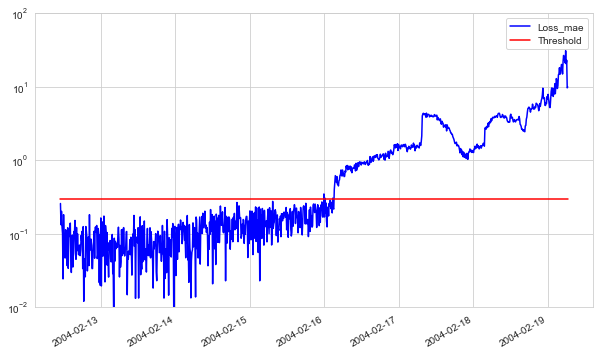

In [39]:
# plot AutoEncoder reconstruction loss over time

scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.show()

Similar to the PCA with Mahalanobis distance method, the chart above shows that the anomaly can be detected on 2004-02-16. One can see that it detects anomaly slightly earlier than the PCA with Mahalanobis distance model. This may due to the choice of the hyperparameter of the model and may also due to Autoencoder doesn't have the assumption that the input data follows Gaussian distribution, which is a constraint of Mahalanobis distance. This requires further investigation.

## 6. Conclusions

Two modelling methods have been discussed to analyze data collected from various measurements of the sensors as means of machine monitoring condition. Both methods showed similar results where they are able to predict the anomaly prior to the actual failure. The main difference between two approaches lays in the definition of a suitable threshold value for anomalies. Based on the results discussed above, the approach using autoencoder of neural network is slightly superior to the one using a combination of PCA and Mahalanobis distance. 